# Solutions for [hands on session 1, day2](hands_on_1.ipynb)

In [21]:
import os
import glob
import nixio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_formats = ['retina'] # only for users with a high resolution display

## Exercise 1: Radar trap scenario

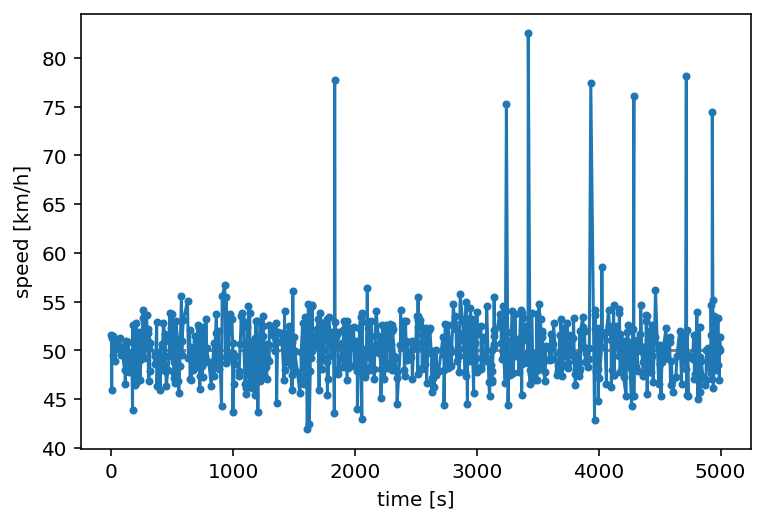

In [8]:


def radar_trap_data(duration=1000, car_probability=0.15, dt=0.01, speed_limit=50, speeder_probability=0.01):
    time = np.arange(0, duration, dt)
    car_times = time[np.random.random(len(time)) < (car_probability * dt)]
    car_speeds = speed_limit + np.random.randn(len(car_times)) * 0.05 * speed_limit
    indices = np.arange(len(car_times), dtype=int)
    np.random.shuffle(indices)
    speeders = indices[:int(np.round(speeder_probability * len(car_times)))]
    car_speeds[speeders] += 0.5 * speed_limit
    fines = car_speeds[speeders] * 1.5 + 15  # Euros ;)

    return car_times, car_speeds, speeders, fines


def plot_raw_data(times, speeds, speed_limit=50):
    plt.plot(times, speeds, marker=".", zorder=2)
    plt.xlabel("time [s]")
    plt.ylabel("speed [km/h]")
    plt.hlines([speed_limit], 0, times[-1], color="grey", ls="--", zorder=1)


times, speeds, speeders, fines = radar_trap_data(duration=5000)
plot_raw_data(times, speeds)

# store data to nix
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("radar trap", "speed_measurements")

speed_array = block.create_data_array("car speeds", "nix.irregular_sampled", data=speeds, label="speed", unit="km/h")
speed_array.append_range_dimension(ticks=times, unit="s", label="time")

speeder_times = times[speeders]
speeder_times_array = block.create_data_array("speeder times", "nix.events", data=speeder_times, label="time", unit="s")
speeder_times_array.append_set_dimension()

speeder_fines_array = block.create_data_array("speeder fines", "nix.data.collection", data=fines, label="fines", unit="EUR")
speeder_fines_array.append_set_dimension()

speeder_tag = block.create_multi_tag("Speeders", "nix.event_detection", positions=speeder_times_array)
speeder_tag.references.append(speed_array)

speeder_tag.create_feature(speeder_fines_array, nixio.LinkType.Indexed)

nixfile.close()

In [9]:
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.ReadOnly)

block = nixfile.blocks["radar trap"]

multi_tag = block.multi_tags["Speeders"]

for i in range(len(multi_tag.positions)):
    speed = multi_tag.tagged_data(i, "car speeds")[:]
    time = multi_tag.positions[i]
    fine = multi_tag.feature_data(i, "speeder fines")[:]
    print(i, time, speed, fine)

nixfile.close()

0 [4288.22] [76.11430999] [129.17146499]
1 [4718.74] [78.17239032] [132.25858547]
2 [1832.33] [77.70345841] [131.55518762]
3 [3241.87] [75.24739319] [127.87108978]
4 [3934.77] [77.46639842] [131.19959763]
5 [4932.06] [74.50285666] [126.75428499]
6 [3421.21] [82.50955717] [138.76433575]


## Exercise 2: add a string feature

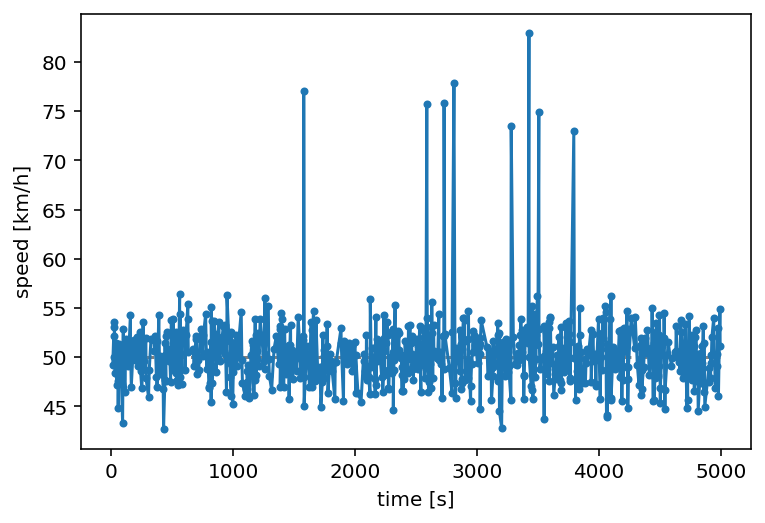

In [17]:
def generate_number_plate():
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    chosen_letters = np.random.choice(list(letters), 4)
    number_plate = "%s-%s-%i" % ("".join(chosen_letters[:2]), "".join(chosen_letters[2:]), np.random.randint(999))
    return number_plate


def radar_trap_data(duration=1000, car_probability=0.15, dt=0.01, speed_limit=50, speeder_probability=0.01):
    time = np.arange(0, duration, dt)
    car_times = time[np.random.random(len(time)) < (car_probability * dt)]
    car_speeds = speed_limit + np.random.randn(len(car_times)) * 0.05 * speed_limit
    indices = np.arange(len(car_times), dtype=int)
    np.random.shuffle(indices)
    speeders = indices[:int(np.round(speeder_probability * len(car_times)))]
    car_speeds[speeders] += 0.5 * speed_limit
    fines = car_speeds[speeders] * 1.5 + 15  # Euros ;)
    
    number_plates = []
    for i in range(len(fines)):
        number_plates.append(generate_number_plate())

    return car_times, car_speeds, speeders, fines, number_plates


times, speeds, speeders, fines, number_plates = radar_trap_data(duration=5000)
plot_raw_data(times, speeds)

# store data to nix
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("radar trap", "speed_measurements")

speed_array = block.create_data_array("car speeds", "nix.irregular_sampled", data=speeds, label="speed", unit="km/h")
speed_array.append_range_dimension(ticks=times, unit="s", label="time")

speeder_times = times[speeders]
speeder_times_array = block.create_data_array("speeder times", "nix.events", data=speeder_times, label="time", unit="s")
speeder_times_array.append_set_dimension()

speeder_fines_array = block.create_data_array("speeder fines", "nix.data.collection", data=fines, label="fines", unit="EUR")
speeder_fines_array.append_set_dimension()

speeder_number_plates = block.create_data_array("number plates", "nix.data.collection", dtype=nixio.DataType.String, data=number_plates)
speeder_number_plates.append_set_dimension()

speeder_tag = block.create_multi_tag("Speeders", "nix.event_detection", positions=speeder_times_array)
speeder_tag.references.append(speed_array)

speeder_tag.create_feature(speeder_fines_array, nixio.LinkType.Indexed)
speeder_tag.create_feature(speeder_number_plates, nixio.LinkType.Indexed)

nixfile.close()

In [20]:
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.ReadOnly)

block = nixfile.blocks["radar trap"]

multi_tag = block.multi_tags["Speeders"]

for i in range(len(multi_tag.positions)):
    speed = multi_tag.tagged_data(i, "car speeds")[:]
    time = multi_tag.positions[i]
    fine = multi_tag.feature_data(i, "speeder fines")[:]
    number_plate = multi_tag.feature_data(i, "number plates")[:]
    print(i, time, number_plate, speed, fine)

nixfile.close()

0 [2727.93] ['QU-FF-553'] [75.84233292] [128.76349938]
1 [2586.31] ['YL-FX-130'] [75.75511993] [128.6326799]
2 [2808.98] ['QS-TH-731'] [77.89462102] [131.84193153]
3 [3278.54] ['KG-KX-711'] [73.48511856] [125.22767784]
4 [1577.02] ['RS-OX-354'] [77.08661488] [130.62992232]
5 [3424.06] ['AS-VL-263'] [82.88745989] [139.33118983]
6 [3792.06] ['JZ-QS-593'] [72.95636178] [124.43454268]
7 [3505.11] ['FY-AA-290'] [74.95134471] [127.42701706]


## Exercise 3: Multidimensional Features

In [56]:
def generate_number_plate():
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    chosen_letters = np.random.choice(list(letters), 4)
    number_plate = "%s-%s-%i" % ("".join(chosen_letters[:2]), "".join(chosen_letters[2:]), np.random.randint(999))
    return number_plate


def get_image():
    imgs = glob.glob(os.path.join("resources", "radar_trap_*.png"))
    img = np.random.choice(imgs)
    img_data = plt.imread(img)
    return img_data


def radar_trap_data(duration=1000, car_probability=0.15, dt=0.01, speed_limit=50, speeder_probability=0.01):
    time = np.arange(0, duration, dt)
    car_times = time[np.random.random(len(time)) < (car_probability * dt)]
    car_speeds = speed_limit + np.random.randn(len(car_times)) * 0.05 * speed_limit
    indices = np.arange(len(car_times), dtype=int)
    np.random.shuffle(indices)
    speeders = indices[:int(np.round(speeder_probability * len(car_times)))]
    car_speeds[speeders] += 0.5 * speed_limit
    fines = car_speeds[speeders] * 1.5 + 15  # Euros ;)
    
    number_plates = []
    pictures = []
    for i in range(len(fines)):
        number_plates.append(generate_number_plate())
        pictures.append(get_image())

    return car_times, car_speeds, speeders, fines, number_plates, pictures

times, speeds, speeders, fines, number_plates, pictures = radar_trap_data(duration=5000)

# store data to nix
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("radar trap", "speed_measurements")

speed_array = block.create_data_array("car speeds", "nix.irregular_sampled", data=speeds, label="speed", unit="km/h")
speed_array.append_range_dimension(ticks=times, unit="s", label="time")

speeder_times = times[speeders]
speeder_times_array = block.create_data_array("speeder times", "nix.events", data=speeder_times, label="time", unit="s")
speeder_times_array.append_set_dimension()

speeder_fines_array = block.create_data_array("speeder fines", "nix.data.collection", data=fines, label="fines", unit="EUR")
speeder_fines_array.append_set_dimension()

speeder_number_plates = block.create_data_array("number plates", "nix.data.collection", dtype=nixio.DataType.String, data=number_plates)
speeder_number_plates.append_set_dimension()

# rearrange the picture data into one np.array with the first dimension representing the number of positions/speeders
picture_data = np.stack(pictures, axis=0)
picture_array = block.create_data_array("pictures", "nix.data.collection.images", data=picture_data)
picture_array.append_set_dimension()
picture_array.append_sampled_dimension(1, label="height", unit="pixel")
picture_array.append_sampled_dimension(1, label="width", unit="pixel")
picture_array.append_set_dimension(labels=["R", "G", "B", "A"])

speeder_tag = block.create_multi_tag("Speeders", "nix.event_detection", positions=speeder_times_array)
speeder_tag.references.append(speed_array)

speeder_tag.create_feature(speeder_fines_array, nixio.LinkType.Indexed)
speeder_tag.create_feature(speeder_number_plates, nixio.LinkType.Indexed)
speeder_tag.create_feature(picture_array, nixio.LinkType.Indexed)

nixfile.close()

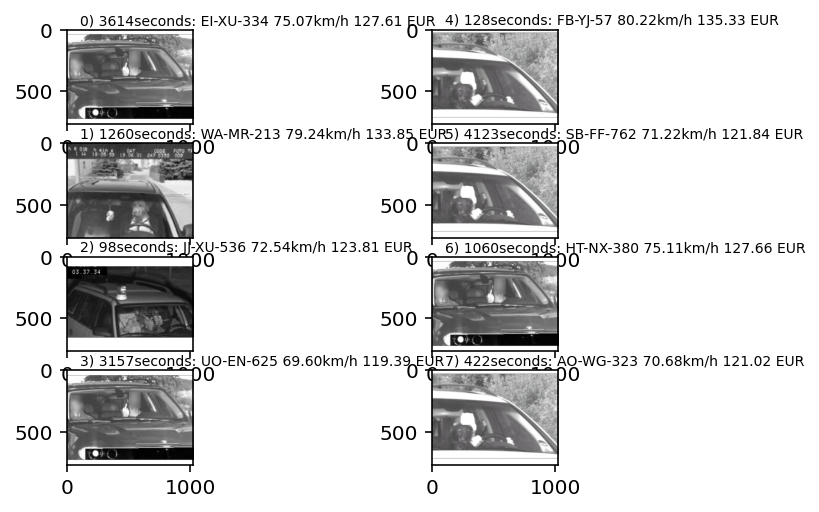

In [55]:
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.ReadOnly)

block = nixfile.blocks["radar trap"]

multi_tag = block.multi_tags["Speeders"]

max_rows = int(np.ceil(len(multi_tag.positions)/2))
fig, axes = plt.subplots(max_rows, 2)

for i in range(len(multi_tag.positions)):
    speed = multi_tag.tagged_data(i, "car speeds")[:]
    time = multi_tag.positions[i]
    fine = multi_tag.feature_data(i, "speeder fines")[:]
    number_plate = multi_tag.feature_data(i, "number plates")[:][0]
    picture = np.squeeze(multi_tag.feature_data(i, "pictures")[:])
    if i < max_rows:
        row_index = i % max_rows
        col_index = 0
    else:
        col_index = 1
        row_index = i - max_rows
    axes[row_index, col_index].imshow(picture)
    axes[row_index, col_index].text(0.1, 1.05, "%i) %iseconds: %s %.2fkm/h %.2f EUR" % (i, time, number_plate, speed, fine),
                                    transform=axes[row_index, col_index].transAxes, fontsize=7)

nixfile.close()